In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import csv
from IPython.display import clear_output
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

In [2]:
class TempVar:
    ''' context manager providing facility for temporary variables in a block
        useful to avoid polluting things with endless temporary variables
    '''
    def __init__(self, **kwargs):
        self.variables = kwargs
        self.old_values = {}

    def __enter__(self):
        glob = globals()
        for k, v in self.variables.items():
            if k in glob:
                self.old_values[k] = glob[k]
            glob[k] = v
        return self.old_values

    def __exit__(self, exc_type, exc_value, traceback):
        glob = globals()
        for k in self.variables:
            if k in self.old_values:
                glob[k] = self.old_values[k]
            else:
                glob.pop(k)

a = 1
print(a)
with TempVar(a=2) as old:
    print(a)
    print(old['a'])
print(a)

1
2
1
1


In [3]:
month = '201305'
month = '200210'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

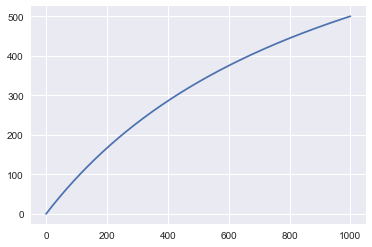

In [5]:
xx = np.arange(0, 1000, 0.1)
yy = xx / (1 + 0.001 * xx)
plt.plot(xx, yy)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


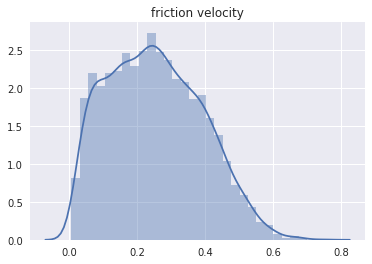

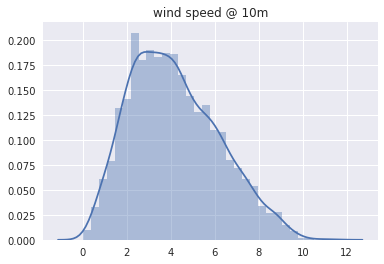

In [7]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

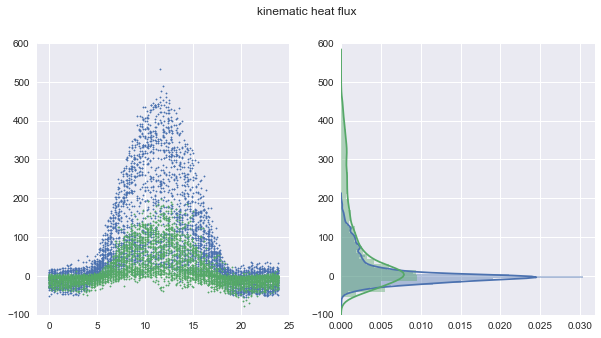

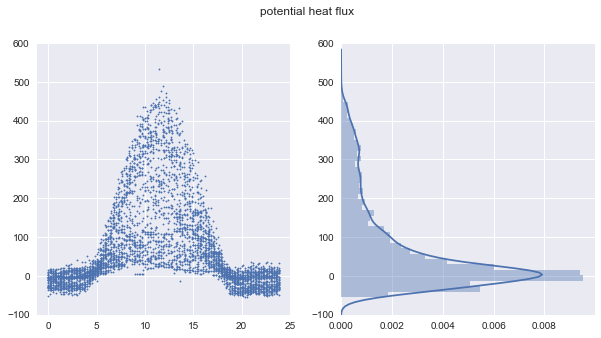

In [3]:
plt.figure(figsize=(10, 5))
plt.suptitle('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.ylim(-100, 600)
plt.show()

plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.ylim(-100, 600)
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


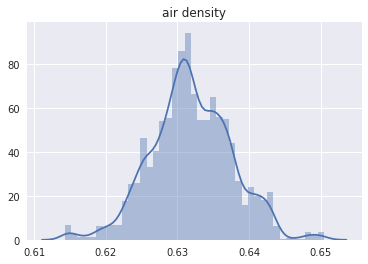

In [9]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

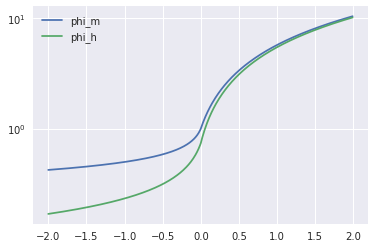

In [10]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

## computing profiles

we need to find a good way to compute $\partial\overline{u}/\partial z$ and $\partial\theta/\partial z$

### polynomial/spline interpolation

C:\Users\edo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


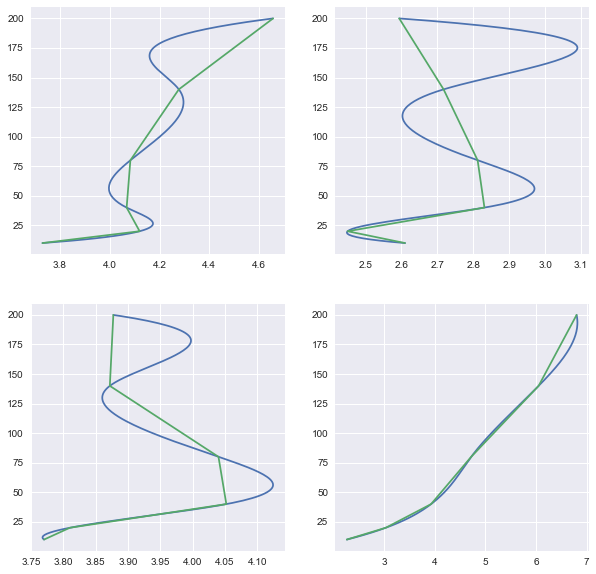

In [22]:
from scipy.interpolate import spline

zi = np.arange(10, 201, 1)

plt.figure(figsize=(10, 10))
for i, tt in enumerate([44, 351, 631, 551]):
    
    wi = spline(towmetds['z'][:6][::-1], towmetds['F'][tt][:-1][::-1], zi, order=3)

    plt.subplot(2, 2, i + 1)
    plt.plot(wi, zi)
    plt.plot(towmetds['F'][tt][:-1], towmetds['z'][:6])

plt.show()

not a good option: the curves are too wiggly. the problem is that the spline passes exactly through all points, and does not allow noise

### non-parametric regression

for wind, we can try gaussian processes with the kernel

$$
k(z_1,z_2)
=\exp\left(-\frac{(z_1-z_2)^2}{2\sigma_0^2}\right)
+\sqrt{\sigma_1^2 z_1 z_2}
+k
+\sigma_2^2\mathbb{1}[z_1=z_2]
$$

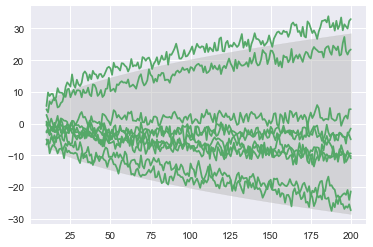

In [23]:
kernel = (
    kernels.RBF()
    + kernels.ConstantKernel()
    + kernels.Exponentiation(kernels.DotProduct(), 0.5)
    + kernels.WhiteKernel()
)

gpr = GaussianProcessRegressor(kernel, normalize_y=True, alpha=0.01)

prior_mean, prior_std = gpr.predict(zi.reshape(-1, 1), return_std=True)
samples = gpr.sample_y(zi.reshape(-1, 1), n_samples=10)

plt.fill_between(zi, prior_mean - 2 * prior_std, prior_mean + 2 * prior_std,
                 color='#bbbbbb', alpha=0.5)

for ss in samples.T:
    plt.plot(zi, ss, 'C1-')

plt.show()

C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.12121564e-07, -2.77547385e-04, -1.61956579e-03,  2.83824262e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Log Marginal Likelihood: -12.2140


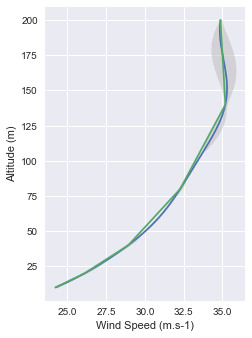

In [70]:
# load dataset 200210
plot_profile(3833)

In [41]:
towmetds['F'][3918]

masked_array(data=[17.026247024536133, 13.224886894226074,
                   8.826955795288086, 5.952960014343262,
                   4.484865188598633, 3.8267462253570557, --],
             mask=[False, False, False, False, False, False,  True],
       fill_value=-9999.0,
            dtype=float32)

Log Marginal Likelihood: -4.9585


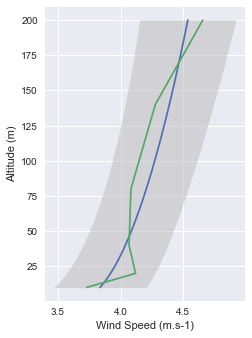

C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.70528095e-05, -2.10409633e-05, -9.65187693e-06,  1.61029789e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -5.37939552e-07, -3.33674649e-03,  1.49580321e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 10, 'warnflag': 2}
  " state: %s" % convergence_dict)


Log Marginal Likelihood: -4.1959


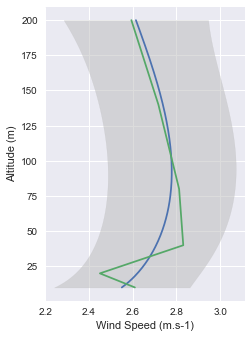

Log Marginal Likelihood: -3.2991


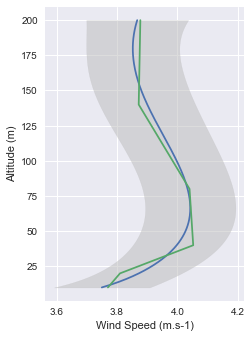

C:\Users\edo\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -1.31404582e-06,  5.95049443e-04,  8.25843486e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Log Marginal Likelihood: -3.6234


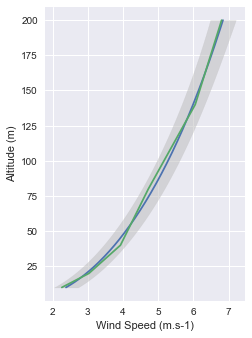

In [68]:
def plot_profile(tt, fname=None):
    alt, measure, noise = towmetds['z'][:6], towmetds['F'][tt][:-1], 0.1
    #alt, measure, noise = towmetds['z'][:], towmetds['TA'][tt][:], 0.5
    
    gpr = GaussianProcessRegressor(
        kernel, n_restarts_optimizer=50, normalize_y=False,
        #alpha=noise**2
    ).fit(
        alt.reshape(-1, 1), measure
    )
    wi, std = gpr.predict(zi.reshape(-1, 1), return_std=True)

    plt.figure(figsize=(0.75 * 4.8, 0.75 * 6.4))
    print('Log Marginal Likelihood: %.4f' % gpr.log_marginal_likelihood())
    plt.fill_betweenx(zi, wi - 2 * std, wi + 2 * std, color='#bbbbbb', alpha=0.5)
    plt.plot(wi, zi)
    plt.plot(measure, alt)
    plt.xlabel('Wind Speed (m.s-1)')
    plt.ylabel('Altitude (m)')
    plt.tight_layout()
    
    if fname:
        plt.savefig(fname)
    
    plt.show()


for i, tt in enumerate([44, 351, 631, 551]):
    plot_profile(tt)

result is pretty cool actually. sometimes the function looks too smooth (top right plot), but considering that the values differ by 0.1/0.2, that might very well be explained by noise in the measurement. the problem is that it takes *ages* to fit

we can differentiate the gaussian process by differentiating the kernel and multiplying by $K(X,X)y$

In [24]:
def kernel(z1, z2):
    # returns value, derivative wrt z1

    params = gpr.kernel_.get_params()
    sigma_0 = params['k1__k1__length_scale']
    sigma_1 = params['k2__kernel__sigma_0']
    k = params['k1__k2__constant_value']
    
    ker = k + np.exp(-(z1-z2)**2/(2*sigma_0**2))+np.sqrt(sigma_1**2+z1*z2)
    der = (
        (z2 - z1)/(sigma_0**2) * np.exp(-(z1-z2)**2/(2*sigma_0**2))
        + z2 / (2 * np.sqrt(sigma_1**2 + z1*z2))
    )

    return ker, der

kernel(10, 20)

(15.141953753119328, 0.7072368501804365)

In [161]:
gpr.kernel_([[10], [20]])

array([[11.00029204, 15.14173897],
       [15.14173897, 21.00026076]])

In [148]:
gpr.predict(zp)

array([4.08501024, 5.28527787, 6.14441531])

In [157]:
eps = 1e-5
(gpr.predict(zp + eps) - gpr.predict(zp - eps)) / (2 * eps)

array([0.02996775, 0.01972772, 0.01512288])

In [150]:
kp = np.array([
    kernel(z1, z2)[1][0]
    for z1 in zp for z2 in zz
]).reshape((len(zp), len(zz)))

kp.dot(alpha)

masked_array(data=[0.02996776, 0.01972771, 0.01512285],
             mask=False,
       fill_value=-9999.0)

for every level in our data, we plot the kernel value with every altitude value

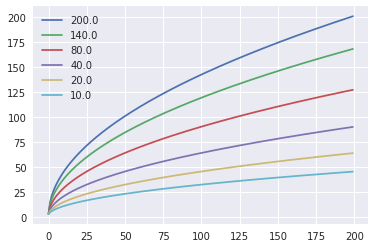

In [66]:
xx = np.arange(0, 200, 1)
kvals = gpr.kernel_(towmetds['z'][:6].reshape(-1, 1), xx.reshape(-1, 1))
for z, k in zip(towmetds['z'][:6], kvals):
    plt.plot(xx, k, label=str(z))
plt.legend()

In [61]:
def gpmodel(zs, ys, noise, zpred=None):
    zpred = zpred if zpred is not None else zs

    kernel = (
        kernels.RBF()
        + kernels.ConstantKernel()
        + kernels.Exponentiation(kernels.DotProduct(), 0.5)
       # + kernels.WhiteKernel()
    )


    (zs, ys), good_data = prepare_arrays(zs, ys)

    gpr = GaussianProcessRegressor(
        kernel, n_restarts_optimizer=50, normalize_y=True,
        alpha=noise**2,
    ).fit(
        zs.reshape(-1, 1), ys
    )

    eps = 0.01
    preds = gpr.predict(np.array([
        (z - eps, z, z + eps)
        for z in zpred.reshape(-1, 1)
    ]).reshape(-1, 1))

    pp = preds[1::3]
    dydz = (preds[2::3] - preds[0::3]) / (2 * eps)

    return pp, dydz

### finite differences

aka difference quotient, obtained by averaging top and bottom derivatives (quantity is $x$ and altitude is $y$)

$$
f^\prime(z)=\frac{1}{2}\cdot\left(
\frac{y_{i+1}-y_i}{z_{i+1}-z_i}+\frac{y_i-y_{i-1}}{z_i-z_{i-1}}
\right)
$$

for boundary values we can only use the previous/next measurement

$$
\frac{\partial x_0}{\partial y_0}=\frac{x_1-x_0}{y_1-y_0}
$$

~~we fill missing values with linear interpolation. this will result in the same gradient, but at least we won't throw away the value~~

we cannot use linear interpolation to fill the value, because the wind profile is not linear, and cannot be approximated like that. instead, we simply skip the value

In [62]:
ProfileData = namedtuple('ProfileData', ['z', 'measure', 'model', 'derivative'])


def prepare_arrays(*arrs):
    # replace masked values with nans
    # then remove element at position i from all arrays
    # if any of them is nan/inf
    # returns cleaned arrays and mask
    mask = np.logical_and(*[
        np.isfinite(np.ma.filled(a, np.nan))
        for a in arrs
    ])

    return [np.array(a)[mask] for a in arrs], mask


def get_derivative(xs, ys):
    # returns dydx by weighted finite differences
    # nans/infs/masked values are skipped in the computation,
    # but preserved in the output (all replaced with nans)
    
    (gxs, gys), good_data = prepare_arrays(xs, ys)

    # compute derivative with good measurements
    gdydx = []
    for i in range(len(gxs)):
        if i == 0:
            d = (gys[i] - gys[i + 1]) / (gxs[i] - gxs[i + 1])
        elif i == len(gxs) - 1:
            d = (gys[i - 1] - gys[i]) / (gxs[i - 1] - gxs[i])
        else:
            #d = (gys[i - 1] - gys[i + 1]) / (gxs[i - 1] - gxs[i + 1])
            d = 0.5 * (
                (gys[i + 1] - gys[i]) / (gxs[i + 1] - gxs[i])
                + (gys[i] - gys[i - 1]) / (gxs[i] - gxs[i - 1])
            )

        gdydx.append(d)

    # insert back nans
    dydx = np.zeros(len(xs))
    dydx[good_data] = gdydx
    dydx[~good_data] = np.nan

    return dydx

### logarithmic wind profile

another option is to model the wind as $u(z)=a+bz+cz^2+d\ln z$, with $\partial u/\partial z=b+2cz+d/z$

In [63]:
def logmodel(zs, ys, zpred=None):
    zpred = zpred if zpred is not None else zs

    (ys, zs), good_data = prepare_arrays(ys, zs)

    features = [(1, z, z**2, np.log(z)) for z in zs]

    mm = LinearRegression(normalize=True).fit(features, ys)

    pp = mm.predict([
        (1, z, z**2, np.log(z)) for z in zpred
    ])

    a, b, c, d = mm.coef_
    dydz = b + 2 * zpred * c + d / zpred

    return pp, dydz

In [64]:
def get_temp_profile(time_index, towmetds, method):
    if method not in {'fdiff', 'log', 'gp'}:
        raise ValueError('unknown method, use fidff, log, or gp')

    zs = towmetds['z'][:]
    virtual_temp = np.ma.filled(towmetds['TA'][time_index] * (
        1 + 0.61 * towmetds['Q'][time_index]
    ), np.nan)

    if method == 'fdiff':
        dtdz = get_derivative(zs, virtual_temp)
        mt = [None] * len(virtual_temp)
    elif method == 'log':
        mt, dtdz = logmodel(zs, virtual_temp)
    else:
        mt, dtdz = gpmodel(zs, virtual_temp, noise=1)

    return ProfileData(z=zs, measure=virtual_temp,
                       derivative=dtdz, model=mt)


def get_wind_profile(time_index, towmetds, method):
    if method not in {'fdiff', 'log', 'gp'}:
        raise ValueError('unknown method, use fidff, log, or gp')

    zs = towmetds['z'][:]
    wind = np.ma.filled(towmetds['F'][time_index], np.nan)
    
    if method == 'fdiff':
        # use no-slip condition to get gradient at bottom level
        zs = list(zs) + [0]
        wind = list(wind) + [0]

        dwdz = get_derivative(zs, wind)
        mw = [None] * len(wind)
    elif method == 'log':
        mw, dwdz = logmodel(zs, wind)
    else:
        mw, dwdz = gpmodel(zs, wind, noise=0.1)

    return ProfileData(z=zs, measure=wind,
                       derivative=dwdz, model=mw)

In [65]:
def plot_profile(time_index, towmetds, quantity, ax=None):
    if quantity == 'wind':
        compute = get_wind_profile
    elif quantity == 'temp':
        compute = get_temp_profile
    else:
        raise ValueError('unknown measure, use wind or temp')

    if ax is None:
        fig, ax = plt.subplots()
    
    ax2 = ax.twiny()
    for method in ['fdiff', 'log', 'gp']:
        prof = compute(time_index, towmetds, method)
        ax.plot(prof.model, prof.z, '.--', label=method)
        ax2.plot(prof.derivative, prof.z, '.-')

    ax.plot(prof.measure, prof.z, 'o-', label='measure')
    ax.legend(loc='best')

    return ax, ax2

/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.30621153e-05,  5.52850805e-06, -1.60136738e-10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 13, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.46706054e-06,  6.10998066e-06,  7.07544025e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.77958838e-02,  6.84602824e-05,  9.10184378e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/lib/python3.6/site-pac

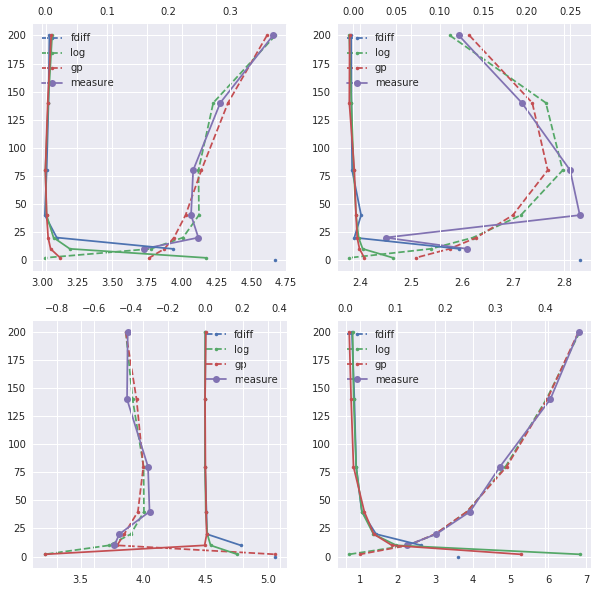

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [a for row in axes for a in row]
for i, (ax, tt) in enumerate(zip(axes, [44, 351, 631, 551])):
    plot_profile(tt, towmetds, 'wind', ax)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -3.45538495e-05,  4.31503449e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        ,  0.00776987, -0.04637744]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  9.76933370e-09,  3.39386851e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Program

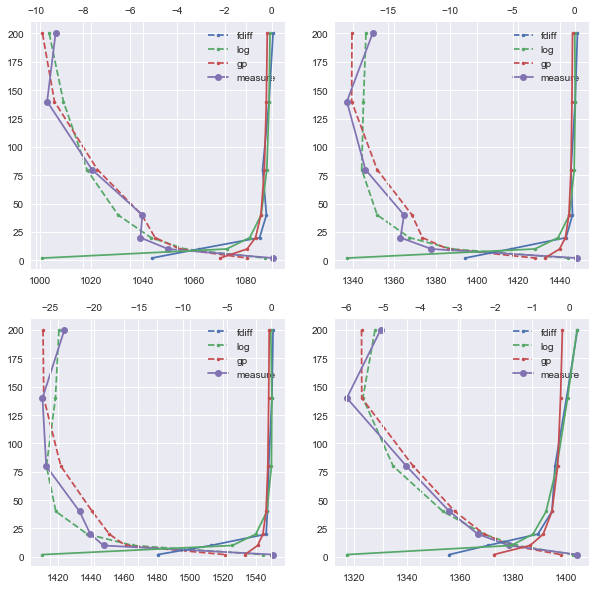

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [a for row in axes for a in row]
for i, (ax, tt) in enumerate(zip(axes, [44, 351, 631, 551])):
    plot_profile(tt, towmetds, 'temp', ax)

## computing data

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [3]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt', 'datetime', 'minute']
computed_cols = ['lval', 'zL', 'model_wind', 'dwdz', 'phi_m', 'model_temp', 'dtdz', 'phi_h']
source_cols = ['IF', 'ITA', 'IQ', 'IP0', 'IRAIN', 'IUST', 'IFC', 'IH', 'ILE', 'IG0', 'IQN']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month, profile_type, **kwargs):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    try:
        soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        soilds = None

    for time_index, tt in enumerate(towmetds['time']):
        # compute profiles
        wind_profile = get_wind_profile(time_index, towmetds, profile_type)
        temp_profile = get_temp_profile(time_index, towmetds, profile_type)

        # process each level separately
        for alt_index, z in enumerate(towmetds['z'][:]):
            if z > 50 or z < 2: # outside of the surface layer
                continue

            # retrieve profiles
            if temp_profile.z[alt_index] == z:
                vtemp = temp_profile.measure[alt_index]
                dtemp = temp_profile.derivative[alt_index]
                mtemp = temp_profile.model[alt_index]
            else:
                vtemp = dtemp = mtemp = np.nan

            if wind_profile.z[alt_index] == z:
                wind = wind_profile.measure[alt_index]
                dwind = wind_profile.derivative[alt_index]
                mwind = wind_profile.model[alt_index]
            else:
                wind = dwind = mwind = np.nan

            # compute things
            spec_hum = towmetds['Q'][time_index, alt_index]
            air_dens = 100 * meteods['P0'][time_index] / (287.058 * vtemp)  # kg.m-3

            virtual_potential_temperature_flux = (
                fluxds['H'][time_index] + 0.07 * fluxds['LE'][time_index]
            ) / (1005 * air_dens)

            lval = -fluxds['UST'][time_index]**3 * vtemp / (
                0.35 * 9.81 * virtual_potential_temperature_flux
            )  # m

            phi_m = dwind * 0.35 * z / fluxds['UST'][time_index]
            phi_h = -(
                dtemp * 0.4 * z * fluxds['UST'][time_index]
                / virtual_potential_temperature_flux
            )

            daym = int(tt / 24)
            hday = tt % 24
            minute = 60 * (hday - int(hday))
            second = 60 * (minute - int(minute))

            dt = datetime.datetime(
                year=int(month[:4]), month=int(month[4:]), day=int(daym) + 1,
                hour=int(hday), minute=int(minute), second=int(second)
            )

            yield RowRecord(
                ds=month,
                tt=tt,
                year=dt.year,
                month=dt.month,
                daym=dt.day,
                hday=dt.hour,
                minute=dt.minute,
                datetime=time.mktime(dt.timetuple()),

                air_dens=air_dens,
                H=fluxds['H'][time_index],
                LE=fluxds['LE'][time_index],
                ustar=fluxds['UST'][time_index],
                temp=towmetds['TA'][time_index, alt_index],
                virtual_temp=vtemp,
                soil_temp=(273.15 + soilds['TS00'][time_index]) if soilds else np.nan,
                wind=wind,

                z=z,
                lval=lval,
                zL=z / lval,
                model_wind=mwind,
                model_temp=mtemp,
                dwdz=dwind,
                dtdz=dtemp,
                phi_m=phi_m,
                phi_h=phi_h,

                IUST=fluxds['IUST'][time_index],
                ILE=fluxds['ILE'][time_index],
                IH=fluxds['IH'][time_index],
                ITA=towmetds['ITA'][time_index, alt_index],
                IF=towmetds['IF'][time_index, alt_index],
                IP0=meteods['IP0'][time_index],
                IQ=towmetds['IQ'][time_index, alt_index],
                IRAIN=meteods['IRAIN'][time_index],
                IFC=fluxds['IFC'][time_index],
                IG0=fluxds['IG0'][time_index],
                IQN=fluxds['IQN'][time_index],

                co2flux=fluxds['FC'][time_index],
                soilheat=fluxds['G0'][time_index],
                netrad=fluxds['QN'][time_index],
                spec_hum=spec_hum,
                dewpoint=towmetds['TD'][time_index, alt_index],
                rel_hum=towmetds['RH'][time_index, alt_index],
                press=meteods['P0'][time_index],
                rain=meteods['RAIN'][time_index],
            )

In [4]:
def get_data(dframe_path, **kwargs):
    compression = 'gzip' if dframe_path.endswith('.gz') else None
    sample_size = 7 if 'sample' in dframe_path else 0
    
    assert not os.path.exists(dframe_path):
    print('recomputing data for %s (you take a coffee)' % dframe_path)
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf

    sc = SparkContext(conf=SparkConf()
        .setMaster('local[7]')
        .set('spark.driver.memory', '14g')
        .set('spark.driver.maxResultSize', '14g'))
    all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

    bad_rows = sc.accumulator(0)    
    def good_row(row):
        is_good = row.ustar > 0.1 and abs(row.H) > 10 and row.wind > 1
        if not is_good:
            bad_rows.add(1)
        return is_good

    try:
        months_rdd = sc.parallelize(all_months, len(all_months))
        if sample_size > 0:
            months_rdd = months_rdd.sample(
                withReplacement=False,
                fraction=sample_size / len(all_months),
                seed=kwargs.get('seed', None)
            )

        df_rows = (months_rdd
            .flatMap(lambda month: process(month, **kwargs))
            .filter(good_row)
            .collect())
    finally:
        sc.stop()

    print(bad_rows.value, 'rows had bad data')
    print('collected', len(df_rows), 'rows of good data')

    df = pd.DataFrame(df_rows)
    df.to_csv(dframe_path, index=False,
              compression='gzip' if dframe_path.endswith('.gz') else None)

    try:
        df = pd.read_csv(dframe_path, na_values='--')
    except (OSError, UnicodeDecodeError):
        df = pd.read_csv(dframe_path, na_values='--', compression='gzip')
    
    return df

In [5]:
df = get_data('data/cabauw/processed-full-log.csv.gz')

1929853 bad rows for the full dataset, and 1506563 good ones